# Ejemplo de resolucion de una EDP en FEcnIS

La ecuacion diferencial parcial a la que queremos encontrar una solucion numerica es
$$\Delta u = x^2+y^2 \quad \text{ en }\Omega$$
$$u=u_{D} \text{ sobre }\partial\Omega$$

Una formulacion variacional de este problema es
$$\int_{\Omega} \nabla v\cdot\nabla u=\int_{S}vf$$
$$u=u_{D} \text{ sobre }\partial\Omega$$
$$v=0 \text{ sobre }\partial\Omega$$
Aqui notemos que las funciones de de prueba deben ser $0$ en el borde.

In [2]:
# Librerias
%matplotlib inline

import numpy as np
from dolfin import *
from mshr import *

import matplotlib.pyplot as plt

In [3]:
# Configuracion
parameters['reorder_dofs_serial'] = False
parameters['allow_extrapolation'] = True

In [4]:
# Definimos el dominio
domain = Circle(Point(.0, .0), 1) - Rectangle(Point(-0.5, -0.5), Point(0.5, 0.5))
domain_mesh = generate_mesh(domain, 20)

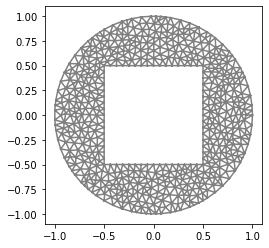

In [6]:
plot(domain_mesh)

In [7]:
# Definimos espacios funcionales
function_space = FunctionSpace(domain_mesh, 'Lagrange', 1)

In [8]:
# Definimos funciones trial y test
u = TrialFunction(function_space)
v = TestFunction(function_space)

In [9]:
# Definimos condiciones de borde
def outer_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and near(np.sqrt(x**2 + y**2), 1, 5e-2)

def top_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0.5)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], -0.5)

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], -0.5)
    
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0.5)

In [10]:
# Inicializamos las condiciones de borde
outer_bc = DirichletBC(function_space, Constant(0), outer_boundary)
top_bc = DirichletBC(function_space, Constant(1), top_boundary)
bottom_bc = DirichletBC(function_space, Constant(-1), bottom_boundary)
left_bc = DirichletBC(function_space, Constant(2), left_boundary)
right_bc = DirichletBC(function_space, Constant(-1), right_boundary)

boundaries = [outer_bc, top_bc, bottom_bc, left_bc, right_bc]

In [11]:
# Definimos las partes del problema variacional
left_integrand = inner(nabla_grad(u), nabla_grad(v)) * dx

f =  Expression("x[0]*x[0]/2 + x[1]*x[1]", degree=1)

right_integrand = f*v*dx

In [12]:
# Ensamblamos el problema de algebra lineal
# Ensamblamos la Matris A
A = assemble(left_integrand)

# Ensamblamos el vector b
b = assemble(right_integrand)

# Aplicamos las condiciones de borde
[bc.apply(A,b) for bc in boundaries]

# Creamos un placeholder para la  solucion
solution = Function(function_space) 

# Calculamos la solucion
solve(A, solution.vector(), b)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


1

Esto se puede realizar de uan manera mas rapida

In [13]:
solution = Function(function_space)
solve(left_integrand == right_integrand, solution, boundaries)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


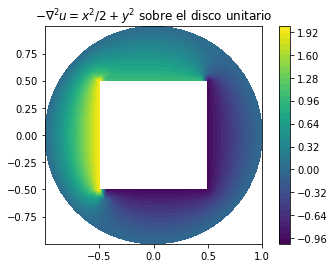

In [14]:
# Visualizacion por defecto
p = plot(solution)
plt.title(r'$-∇ ^2 u = x^2/2+y^2$ sobre el disco unitario')
plt.colorbar(p)
plt.show()

Ahora una visualizacion 3D de la solucion

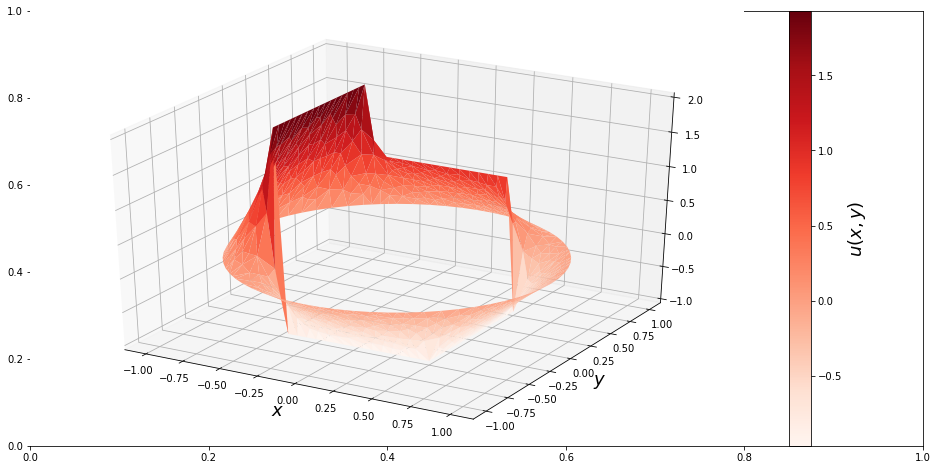

In [15]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

def mesh_triangulation(mesh):
    """
    Convierte la malla de FeniCS a una triangulacion de matplotlib
    """
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    return mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)

triangulation = mesh_triangulation(domain_mesh)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)

c = ax.plot_trisurf(triangulation, np.array(solution.vector()),cmap=mpl.cm.get_cmap("Reds"))

cb = plt.colorbar(c, ax=ax)

cb.set_label(r"$u(x, y)$", fontsize=18)